#### Adam Mischke
#### CSCI 4850-5850 - Neural Networks
#### Open Lab 3
#### Due: Apr. 19 @ 11:00pm (I tried)
#### General Sequence-to-Sequence Mappings

In [1]:
# imports
import keras
import numpy as np 
import matplotlib.pyplot as plt 
% matplotlib inline 

from keras_tqdm import TQDMNotebookCallback
# Visualization 
from IPython.display import SVG 
from IPython.display import display 
from keras.utils.vis_utils import model_to_dot

/home/csci4850/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1. Utilize the methods learned in the tutorial above to train an encoder-decoder network to solve the P&P text learning problem usingthe first 50 sentences from the text.

#### Load the data and prepare the data as described above

In [2]:
# preprocessing
with open('/home/share/gutenberg_example/PandP_Jane_Austen.txt','r',encoding='utf-8') as f:
    lines = f.read().split('\n')
text=[]
for i in range(len(lines)):
    if lines[i]!='':
        text=text+[lines[i]]
min_length=max([len(i) for i in text])

# unique characters
with open('/home/share/gutenberg_example/unique_chars.txt','r',encoding='utf-8') as f:
    lines = f.read().split('\n')
    
# integer code to symbol
itos = ['', '', ' ']

for i in lines:
    itos = itos + [i]
    
# symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1

for i in range(2, len(itos)):
    stoi[itos[i]] = i
        
# total number of sentences
print('total number of sentences:', len(text))

# longest sentence
print('longest sentence:', max(len(i) for i in text) + 2)

# number of tokens
print('number of tokens:', len(itos))

total number of sentences: 10658
longest sentence: 76
number of tokens: 71


In [3]:
# setting up our one-hot encoding and decoding functions

def encode_seq(x,mapping,min_length=0):
    # String to one-hot
    y=[mapping['START']]
    for i in list(x):
        y=y+[mapping[i]]
    y=y+[mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y)<min_length:
        y=y+[mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))
    
def decode_seq(x,mapping):
    # One-hot to string
    y=[] 
    for i in x:
        y=y+[mapping[np.argmax(i)]]
    return ''.join(y)

# checking to make sure our encoding/decoding works
# by encoding - decoding cycle on the first line
"""
temp = encode_seq(text[0], stoi)
temp = decode_seq(temp, itos)
print('before encoded:', text[0])
print('decoded:', temp)
"""

"\ntemp = encode_seq(text[0], stoi)\ntemp = decode_seq(temp, itos)\nprint('before encoded:', text[0])\nprint('decoded:', temp)\n"

In [4]:
# encode the data
dataX=np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))

for i in range(len(text)):
    temp=encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:]=temp

# set Y as well
dataY=np.ones([len(text),max([len(i)for i in text])+2,len(itos)])*(1.0/len(itos)) 
for i in range(len(text)):
    temp=encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:]=temp
    
    
X=dataX[0:dataX.shape[0]-1,:,:]
Y=dataY[1:dataY.shape[0],:,:]
preY=Y[:,0:Y.shape[1]-1,:]
postY=Y[:,1:Y.shape[1],:]


nlines=50
X=X[0:nlines,:,:]
Y=Y[0:nlines,:,:]
preY=preY[0:nlines,:,:]
postY=postY[0:nlines,:,:]

print('Number of lines:', nlines)
print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('preY shape:', preY.shape)
print('postY shape:', postY.shape)

Number of lines: 50
X shape: (50, 76, 71)
Y shape: (50, 76, 71)
preY shape: (50, 75, 71)
postY shape: (50, 75, 71)


#### Build the encoder-decoder network for the task

In [5]:
#activation = 'relu'
#activation = 'softsign'
activation = 'tanh'

input_length = max(len(i) for i in text) + 2
# size of gestalt context representation
# (76 * 6 = 456)
hidden_size = input_length * 10

# encoder construction
# make layers
encoder_input = keras.layers.Input(shape= (None, X.shape[2]))

encoder_hidden = keras.layers.LSTM(hidden_size, return_state = True, return_sequences = True, activation=activation)
#encoder_hidden = keras.layers.Dropout(0.25)(encoder_hidden)

# tie the hidden layer to the input layer
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# discard encoder outputs and keep only the states
encoder_states = [enc_state_h, enc_state_c]

# decoder construction
# set up the decoder using encoder states as the initial state
decoder_input = keras.layers.Input(shape= (None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences = True, return_state = True, activation=activation)

# connect hidden to input
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input, initial_state = encoder_states)


decoder_dense = keras.layers.Dense(postY.shape[2], activation = 'softmax')

# connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)

# Our functoinal API model now has two input layers..
# 1. reads from X
# 2. reads from preY
# single output layer
# 1. targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# compile it
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 760),  2529280     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 760),  2529280     input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

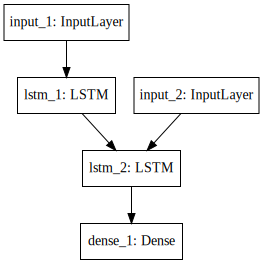

In [6]:
# visualization 
SVG(model_to_dot(model).create(prog='dot',format='svg'))

#### Train your network (include the loss and accuracy plot)

In [7]:
# 50/2 = 25 batches
batch_size=nlines // 2
# number of time steps
epochs=200

# train
history=model.fit([X,preY],postY,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  callbacks=[TQDMNotebookCallback()])

# evaluate
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=50), HTML(value='')))


50/50 [==============================] - 4s 89ms/step
Accuracy: 78.23999977111816 %


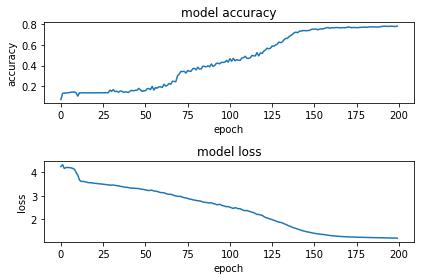

In [8]:
# plot the results

plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

#### Build your encoder_model and decoder_model tesing networks

In [9]:
# testing

# Part 1 - make the encoder
# make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model=keras.Model(encoder_input, encoder_states)

# Part 2 - make the decoder
# make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h=keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c=keras.layers.Input(shape=(hidden_size,))

# connect hidden to input
decoder_states_input=[decoder_state_input_h,decoder_state_input_c]
decoder_hidden_output,decoder_state_h,decoder_state_c = decoder_hidden(decoder_input,
                                                                       initial_state=decoder_states_input)
decoder_states=[decoder_state_h,decoder_state_c]

# connect output to hidden
decoder_output=decoder_dense(decoder_hidden_output)
decoder_model=keras.Model(
    [decoder_input]+decoder_states_input,
    [decoder_output]+decoder_states)

In [10]:
# get the gestalt context for the input sequence(s)
i=0
context=encoder_model.predict(X[i:i+1,:,:])

# prep a starting token...
token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]])

In [13]:
# What should we see?
print('Input:',text[i])
print('Output:',text[i+1])

Input: It is a truth universally acknowledged, that a single man in possession
Output: of a good fortune, must be in want of a wife.


In [14]:
# Complete max cycles with the decoder
result=np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c=decoder_model.predict([token]+context)
    token=np.round(out)
    context=[h,c]
    result[:,x,:]=token
    
decode_seq(result[0,:,:],itos)

' o o ot o tha at teeo o w be snere '

#### Test your networks using teacher forcing (50 sentences)

In [ ]:
# Iterate - teacher forcing through each line
for i in range(0,nlines):
    # Get the gestalt context for the input sequence(s)
    context=encoder_model.predict(X[i:i+1,:,:])
    
    # Prep a starting token...
    token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    
    result=np.zeros([1,postY.shape[1],postY.shape[2]])
    
    """
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token[:,:,:] = 0.0
        token[:,:,np.argmax(out)] = 1.0
        context = [h,c]
        result[:,x,:] = token
        if decode_seq(token,itos) == '':
            break
    """
    
    for x in range(postY.shape[1]):
        out,h,c=decoder_model.predict([token]+context)
        token=np.round(out)
        context=[h,c]
        result[:,x,:]=token
    
    
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

#### Test your networks without teacher forcing (50 sentences)

In [ ]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i=0
context=encoder_model.predict(X[i:i+1,:,:])
for i in range(0,nlines):
    # Prep a starting token...
    token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    
    result=np.zeros([1,postY.shape[1],postY.shape[2]])
    """
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token[:,:,:] = 0.0
        token[:,:,np.argmax(out)] = 1.0
        context = [h,c]
        result[:,x,:] = token
        if decode_seq(token,itos) == '':
            break
    
    """
    for x in range(postY.shape[1]):
        out,h,c=decoder_model.predict([token]+context)
        token=np.round(out)
        context=[h,c]
        result[:,x,:]=token
    
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context=encoder_model.predict(result)

### 2.Load up the P&P data again, but this time split the data intowords instead oflines. By words I simply meandivided by whitespace,so you can have words that only contain punctuation. Utilize the methods learned in the tutorial above to train an encoder-decodernetwork to solve the P&P text learning problem using the first 500 words in the text. You will be using one word to predict the next word. (Critical note:words are significantly shorter than lines, so the number of time steps used by your network is farreduced and will significantly decrease the training time required.)

#### Load the data and prepare the data as described above (split into words)

In [ ]:
# Preprocessing - grab lines from the file

import string

nwords = 500

table = str.maketrans({key: None for key in string.punctuation})

with open('/home/share/gutenberg_example/PandP_Jane_Austen.txt','r',encoding='utf-8') as f:
    lines = f.read().replace(' ', '\n').split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text=[]

lines = [i.translate(table) for i in lines]
lines = [i for i in lines if i]

text = lines[:nwords+1]

min_length=max([len(i) for i in text])


# unique characters - precalculated
with open('/home/share/gutenberg_example/unique_chars.txt','r',encoding='utf-8') as f:
    lines = f.read().split('\n')
    
# integer code to symbol
itos = ['', '', ' ']

for i in lines:
    itos = itos + [i]
    
# symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1

for i in range(2, len(itos)):
    stoi[itos[i]] = i
    
# total number of words
print('total number of words:', len(text))

# longest word
print(max(len(i) for i in text) + 2)

# number of tokens
print(len(itos))


#### Build the encoder-decoder network for the task

In [ ]:
# Encode that data
dataX=np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))

for i in range(len(text)):
    temp=encode_seq(text[i],stoi, min_length)
    dataX[i,0:len(temp),:]=temp
    
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY=np.ones([len(text),max([len(i)for i in text])+2,len(itos)])*(1.0/len(itos)) 
for i in range(len(text)):
    temp=encode_seq(text[i],stoi, min_length)
    dataY[i,0:len(temp),:]=temp
    
    
X=dataX[0:dataX.shape[0]-1,:,:]
Y=dataY[1:dataY.shape[0],:,:]
preY=Y[:,0:Y.shape[1]-1,:]
postY=Y[:,1:Y.shape[1],:]


X=X[0:nwords,:,:]
Y=Y[0:nwords,:,:]
preY=preY[0:nwords,:,:]
postY=postY[0:nwords,:,:]

print('Number of words:', nwords)
print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('preY shape:', preY.shape)
print('postY shape:', postY.shape)

In [ ]:
#activation = 'relu'
activation = 'tanh'

input_length = max(len(i) for i in text) + 2
# size of gestalt context representation
hidden_size = input_length * 20

# encoder construction
# make layers
encoder_input = keras.layers.Input(shape= (None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state = True, activation=activation)

#DOUBLE
#encoder_hidden = keras.layers.LSTM(hidden_size, return_sequences = True, return_state = True, activation = activation)
#encoder_hidden2 = keras.layers.LSTM(hidden_size,  return_state = True, activation = activation)


# tie the hidden layer to the input layer
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# discard encoder outputs and keep only the states
encoder_states = [enc_state_h, enc_state_c]

#encoder_output2, enc_state_h2, enc_state_c2 = encoder_hidden2(encoder_hidden(encoder_input))

# discard encoder outputs and keep only the states
#encoder_states2 = [enc_state_h2, enc_state_c2]


# decoder construction
# set up the decoder using encoder states as the initial state
decoder_input = keras.layers.Input(shape= (None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences = True, return_state = True, activation=activation)
#decoder_hidden2 = keras.layers.LSTM(hidden_size,  return_sequences = True, return_state = True, activation = activation)



# connect hidden to input
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input, initial_state = encoder_states)
#decoder_hidden_output2, decoder_state_h2, decoder_state_c2 = decoder_hidden2(decoder_hidden(decoder_input, initial_state = encoder_states2))


decoder_dense = keras.layers.Dense(postY.shape[2], activation = 'softmax')

# connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)

# functoinal API model now has two input layers..
# 1. reads from X
# 2. reads from preY
# single output layer
#1. targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# compile it
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

model.summary()


#### Train your network (include the loss and accuracy plot)

In [ ]:
# 5
batch_size=nwords // 5
# number of patterns...
epochs=45


history=model.fit([X,preY],postY,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  callbacks=[TQDMNotebookCallback()])

print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

In [ ]:
# plotting
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

#### Build your encoder_model and decoder_model tesing networks

In [26]:
# testing

# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model=keras.Model(encoder_input, encoder_states)

# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h=keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c=keras.layers.Input(shape=(hidden_size,))

# Connect hidden to input(s)
decoder_states_input=[decoder_state_input_h,decoder_state_input_c]
decoder_hidden_output,decoder_state_h,decoder_state_c = decoder_hidden(decoder_input,
                                                                       initial_state=decoder_states_input)
decoder_states=[decoder_state_h,decoder_state_c]

# Connect output to hidden(s)
decoder_output=decoder_dense(decoder_hidden_output)
decoder_model=keras.Model([decoder_input]+decoder_states_input,[decoder_output]+decoder_states)

#### Test your networks using teacher forcing (500 words)

In [27]:
# Iterate - teacher forcing through each line
for i in range(0,nwords):
    # Get the gestalt context for the input sequence(s)
    context=encoder_model.predict(X[i:i+1,:,:])
    
    # Prep a starting token...
    token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    
    result=np.zeros([1,postY.shape[1],postY.shape[2]])
    """
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token[:,:,:] = 0.0
        token[:,:,np.argmax(out)] = 1.0
        context = [h,c]
        result[:,x,:] = token
        if decode_seq(token,itos) == '':
            break
    
    """
    for x in range(postY.shape[1]):
        out,h,c=decoder_model.predict([token]+context)
        token=np.round(out)
        context=[h,c]
        result[:,x,:]=token
    
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))


            

Txt: is
Net: the
Txt: a
Net: the
Txt: truth
Net: the
Txt: universally
Net: the
Txt: acknowledged
Net: the
Txt: that
Net: the
Txt: a
Net: the
Txt: single
Net: the
Txt: man
Net: the
Txt: in
Net: the
Txt: possession
Net: the
Txt: of
Net: the
Txt: a
Net: the
Txt: good
Net: the
Txt: fortune
Net: the
Txt: must
Net: the
Txt: be
Net: the
Txt: in
Net: the
Txt: want
Net: the
Txt: of
Net: the
Txt: a
Net: the
Txt: wife
Net: the
Txt: However
Net: the
Txt: little
Net: the
Txt: known
Net: the
Txt: the
Net: the
Txt: feelings
Net: the
Txt: or
Net: the
Txt: views
Net: the
Txt: of
Net: the
Txt: such
Net: the
Txt: a
Net: the
Txt: man
Net: the
Txt: may
Net: the
Txt: be
Net: the
Txt: on
Net: the
Txt: his
Net: the
Txt: first
Net: the
Txt: entering
Net: the
Txt: a
Net: the
Txt: neighbourhood
Net: the
Txt: this
Net: the
Txt: truth
Net: the
Txt: is
Net: the
Txt: so
Net: the
Txt: well
Net: the
Txt: fixed
Net: the
Txt: in
Net: the
Txt: the
Net: the
Txt: minds
Net: the
Txt: of
Net: the
Txt: the
Net: the
Txt: surro

#### Test your networks without using teacher forcing (500 words)

In [28]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i=0
context=encoder_model.predict(X[i:i+1,:,:])
for i in range(0,nwords):
    # Prep a starting token...
    token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    
    result=np.zeros([1,postY.shape[1],postY.shape[2]])
    """
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token[:,:,:] = 0.0
        token[:,:,np.argmax(out)] = 1.0
        context = [h,c]
        result[:,x,:] = token
        if decode_seq(token,itos) == '':
            break
    
    """
    for x in range(postY.shape[1]):
        out,h,c=decoder_model.predict([token]+context)
        token=np.round(out)
        context=[h,c]
        result[:,x,:]=token
    
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context=encoder_model.predict(result)

Txt: is
Net: the
Txt: a
Net: the
Txt: truth
Net: the
Txt: universally
Net: the
Txt: acknowledged
Net: the
Txt: that
Net: the
Txt: a
Net: the
Txt: single
Net: the
Txt: man
Net: the
Txt: in
Net: the
Txt: possession
Net: the
Txt: of
Net: the
Txt: a
Net: the
Txt: good
Net: the
Txt: fortune
Net: the
Txt: must
Net: the
Txt: be
Net: the
Txt: in
Net: the
Txt: want
Net: the
Txt: of
Net: the
Txt: a
Net: the
Txt: wife
Net: the
Txt: However
Net: the
Txt: little
Net: the
Txt: known
Net: the
Txt: the
Net: the
Txt: feelings
Net: the
Txt: or
Net: the
Txt: views
Net: the
Txt: of
Net: the
Txt: such
Net: the
Txt: a
Net: the
Txt: man
Net: the
Txt: may
Net: the
Txt: be
Net: the
Txt: on
Net: the
Txt: his
Net: the
Txt: first
Net: the
Txt: entering
Net: the
Txt: a
Net: the
Txt: neighbourhood
Net: the
Txt: this
Net: the
Txt: truth
Net: the
Txt: is
Net: the
Txt: so
Net: the
Txt: well
Net: the
Txt: fixed
Net: the
Txt: in
Net: the
Txt: the
Net: the
Txt: minds
Net: the
Txt: of
Net: the
Txt: the
Net: the
Txt: surro

### 3.Describe any differences in the learning behaviours observed from Problems 1 and 2

Problem 2 seemed easier to nail down than problem 1 for me, although that may just be because there were less parameters in 2, so I could train and test it easier. I spent at least 2-3 days working on this, staring at the output trying to get sentences and words to come out either non-jumbled or non-' '. After applying argmax instead of round, the output seemed better. The models are extremely easy to overtrain even then, to only spitting out the same word/sentence over and over again. Jupyter is also being crazy slow tonight, sometimes not even loading the model into memory. I've been watching top and a lot of the RAM and CPU are being eaten up on all of the jupyters (I usually do the labs early, so I guess this must be normal.) I couldn't get the models to work like how I wanted, but I'm going to turn it in for now because the deadline is almost here.